## Load the Network

In [3]:
from rlsm.datasets import load_lawyers
from rlsm.covariates import dyad_cat_diff, dyad_nominal_diff

Y, features = load_lawyers()

X_dyad = np.dstack([
    dyad_cat_diff(features['female']),
    dyad_cat_diff(features['practice']),
    dyad_nominal_diff(features['seniority']),
])

## Conditionally Edge-Independent LSM

In [49]:
from rlsm import ReciprocityLSM

model_none = ReciprocityLSM(n_features=2, reciprocity_type='none', random_state=42)
model_none.sample(Y, X_dyad=X_dyad, n_warmup=2500, n_samples=5000)

sample: 100%|██████████████████████████████████████████████| 7500/7500 [06:57<00:00, 17.98it/s, 63 steps of size 5.14e-02. acc. prob=0.84]


In [8]:
model_none.print_summary()

AUC: 0.939, AIC: 2949.135, BIC: 4817.843, DIC: 2823.824

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
beta_dyad[0]      0.46      0.14      0.46      0.18      0.75   4153.48      1.00
beta_dyad[1]      1.87      0.13      1.87      1.62      2.14   4640.80      1.00
beta_dyad[2]     -0.07      0.01     -0.07     -0.08     -0.05   2814.42      1.00
       r_var      2.30      0.55      2.23      1.34      3.40   1226.70      1.00
       s_var      1.85      0.47      1.78      1.02      2.79   1528.88      1.00
     sr_corr     -0.44      0.18     -0.43     -0.78     -0.05    649.20      1.00
       z_var      5.00      0.82      4.94      3.51      6.63   1433.96      1.00

Number of divergences: 36


## Homogeneous Model

In [55]:
model_con = ReciprocityLSM(n_features=2, reciprocity_type='constant', random_state=42)
model_con.sample(Y, X_dyad=X_dyad, n_warmup=2500, n_samples=5000)

sample: 100%|██████████████████████████████████████████████| 7500/7500 [19:45<00:00,  6.33it/s, 63 steps of size 5.47e-02. acc. prob=0.82]


In [10]:
model_con.print_summary()

AUC: 0.939, AIC: 2947.673, BIC: 4623.265, DIC: 2816.609

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
beta_dyad[0]      0.43      0.14      0.43      0.16      0.70   3863.24      1.00
beta_dyad[1]      1.73      0.13      1.73      1.47      1.99   2908.06      1.00
beta_dyad[2]     -0.06      0.01     -0.06     -0.08     -0.04   3754.31      1.00
       r_var      2.46      0.57      2.40      1.46      3.59   1630.75      1.00
  recip_coef      0.77      0.19      0.77      0.41      1.15   3931.19      1.00
       s_var      2.00      0.49      1.95      1.12      2.97   1484.77      1.00
     sr_corr     -0.66      0.18     -0.67     -1.00     -0.35    984.41      1.01
       z_var      4.37      0.76      4.29      3.01      5.96   1510.53      1.00

Number of divergences: 44


## Reciprocity Coeffient and Latent Space (Figure 6)

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_92243/2776180659.py:16: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model_con.Z_))


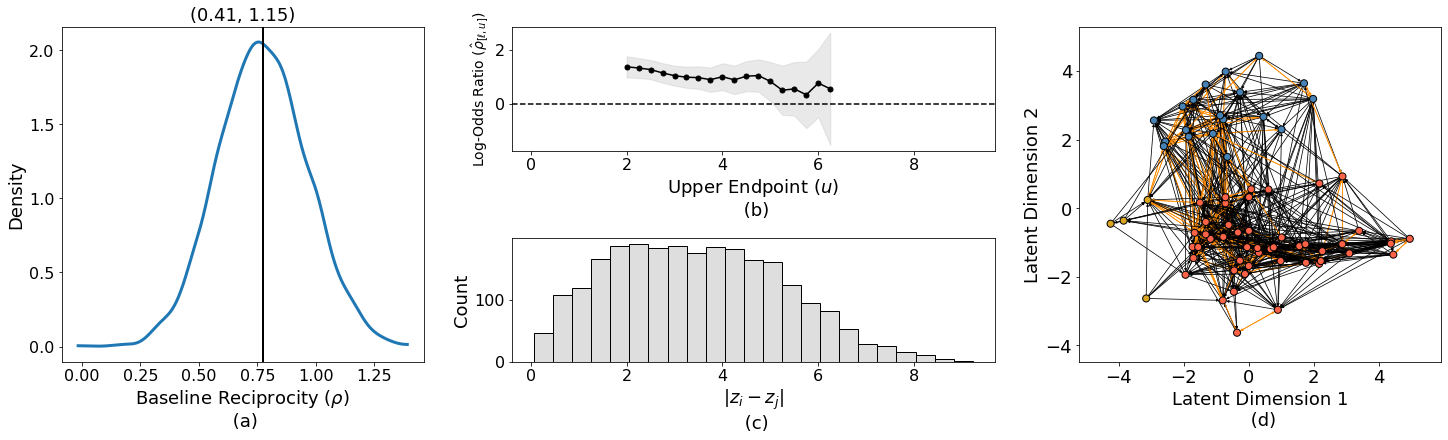

In [8]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans
import arviz as az


ax = plt.figure(constrained_layout=True, figsize=(20,6)).subplot_mosaic(
    """
    DDDAAAABBB
    DDDCCCCBBB
    """,
    gridspec_kw={'wspace': 0.2}
)

D = np.sqrt(pairwise_distance(model_con.Z_))
d = adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
prods = []
diff = np.diff(qs)[0] 

start = 0
step = 2
end = start + step
while start < d.max():
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= start, d <= end))[0]])
    
    tots = a.sum(axis=0) 
    prods.append(tots[1] * tots[2])
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if np.prod(tots) > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(end)
        
    start += 0.25
    end += 0.25

sns.histplot(d, color='lightgray', edgecolor='k', ax=ax['C'])
ax['A'].plot(np.asarray(dist), res, 'ko-', markersize=5)
ax['A'].set_ylabel(r'Log-Odds Ratio $(\hat{\rho}_{[\ell, u]})$', fontsize=14)
ax['A'].set_xlabel('Upper Endpoint ($u$)\n (b)', fontsize=18)
ax['C'].set_ylabel('Count', fontsize=18)
ax['C'].set_xlabel(r'$|z_i - z_j|$'+ '\n (c)', fontsize=18)
ax['A'].axhline(0., color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

colors = np.asarray(["tomato", "steelblue", "goldenrod"])
g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model_con.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=colors[features['office']-1],
                 #node_color='steelblue', 
                 edgecolors='k',
                 edge_color=ecolor, width=0.75, with_labels=False,
                 arrowsize=5,
                 node_size=50., ax=ax['B'])
ax['A'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=16)
ax['C'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=16)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=18)
ax['B'].set_ylabel('Latent Dimension 2', fontsize=18)
ax['B'].set_xlabel('Latent Dimension 1\n (d)', fontsize=18)
ax['A'].sharex(ax['C'])

rho = model_con.samples_['recip_coef']
rho_ci = np.quantile(rho, q=[0.025, 0.975])
ax['D'] = az.plot_kde(model_con.samples_['recip_coef'], plot_kwargs={'linewidth': 3}, ax=ax['D'])
ax['D'].axvline(rho.mean(), linestyle='-', color='k', linewidth=2)
ax['D'].set_title(f"({rho_ci[0]:.2f}, {rho_ci[1]:.2f})", fontsize=18)
ax['D'].set_xlabel(r"Baseline Reciprocity ($\rho$)" + "\n (a)", fontsize=18)
ax['D'].set_ylabel(r"Density", fontsize=18)
ax['D'].tick_params(labelsize=16)

## Distance-Dependent Model

In [23]:
model_dis = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=42)
model_dis.sample(Y, X_dyad=X_dyad, n_warmup=2500, n_samples=5000)

sample: 100%|█████████████████████████████████████████████| 7500/7500 [10:29<00:00, 11.91it/s, 127 steps of size 4.49e-02. acc. prob=0.87]


In [13]:
model_dis.print_summary()

AUC: 0.939, AIC: 2949.714, BIC: 4631.124, DIC: 2816.268

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
beta_dyad[0]      0.43      0.14      0.43      0.16      0.71   4294.28      1.00
beta_dyad[1]      1.73      0.13      1.73      1.45      1.98   3319.80      1.00
beta_dyad[2]     -0.06      0.01     -0.06     -0.08     -0.04   3614.37      1.00
   dist_coef     -0.09      0.20     -0.08     -0.46      0.32   1574.14      1.00
       r_var      2.46      0.59      2.38      1.44      3.70   2161.73      1.00
  recip_coef      0.94      0.42      0.93      0.09      1.72   1968.16      1.00
       s_var      2.00      0.48      1.95      1.14      2.96   1759.95      1.00
     sr_corr     -0.65      0.18     -0.66     -0.99     -0.35   1390.66      1.00
       z_var      4.27      0.76      4.21      2.90      5.81   1676.68      1.00

Number of divergences: 37


## Goodness-of-Fit (Figure 5)

In [14]:
from rlsm.gof import reciprocity

res_dis = model_dis.posterior_predictive(reciprocity)
res_con = model_con.posterior_predictive(reciprocity)
res_no = model_none.posterior_predictive(reciprocity)

<IPython.core.display.Javascript object>


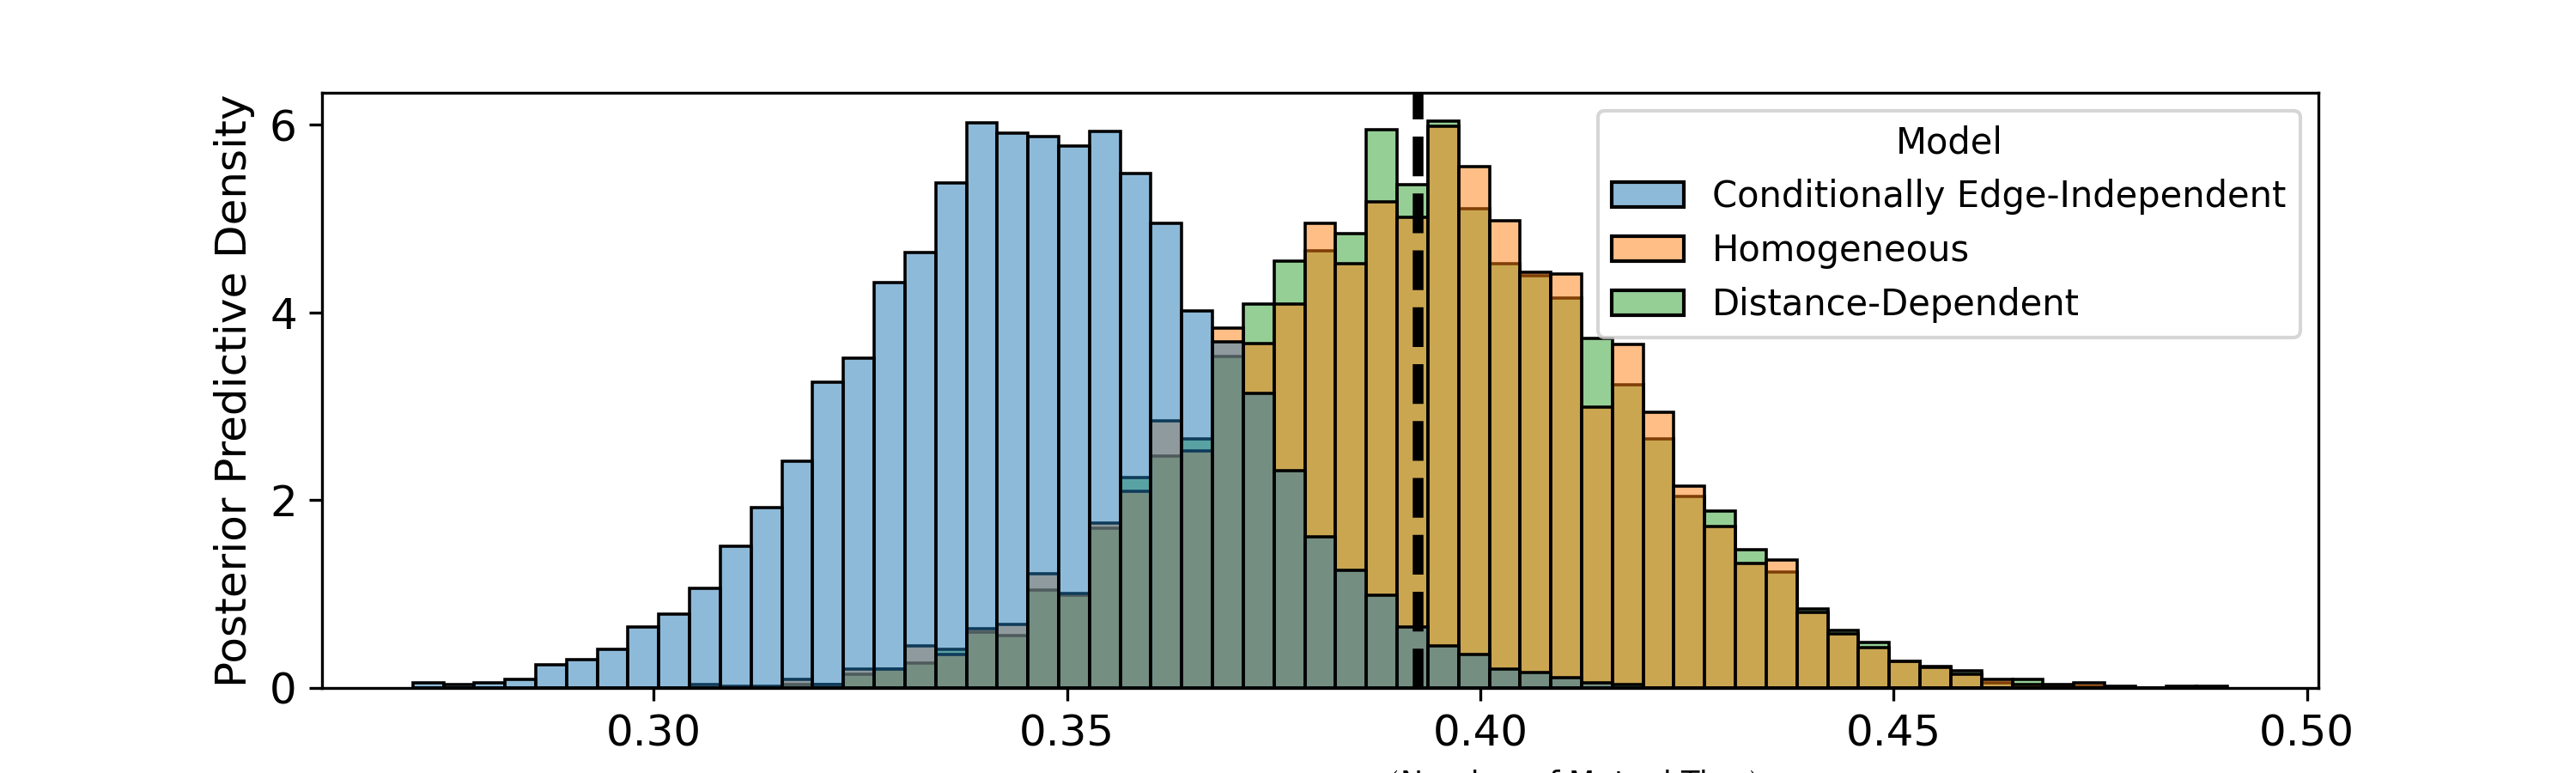

In [20]:
res_obs = reciprocity(Y, is_adj=True)

fig, ax = plt.subplots(figsize=(10, 3))
data = pd.DataFrame({
    'Distance-Dependent': res_dis, 
    'Homogeneous': res_con, 
    'Conditionally Edge-Independent': res_no
})
data = pd.melt(data)
data.columns = ['Model', 'value']
sns.histplot(x='value', data=data, hue='Model', stat='density', ax=ax, 
             hue_order=['Conditionally Edge-Independent', 'Homogeneous', 
                        'Distance-Dependent'])
ax.axvline(res_obs, color='k', linestyle='--', linewidth=3)
ax.set_xlabel(r'Fraction of Mutual Ties '
              r'$\left(\frac{\text{Number of Mutual Ties}}{\text{Number of Ties}}\right)$', 
              fontsize=12)
ax.set_ylabel('Posterior Predictive Density', fontsize=12)
ax.tick_params(labelsize=12)